In [2]:
import bisect
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

##Load Dataset

In [3]:
data = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/Fraud/Fraud_Data.csv', 
                   parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
addressToCountry = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/Fraud/IpAddress_to_Country.csv')
addressToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


##Add Country to Dataset

Firstly, for each user, determine her country based on the numeric IP address.

In [6]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = addressToCountry[(addressToCountry['lower_bound_ip_address'] <= ip_address) &
                           (addressToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


##Feature Engineering

A few obvious variables that can be created here could be:

    Time difference between sign-up time and purchase time
    If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
    Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
    Usual week of the year and day of the week from time variables

In [7]:
# It is very suspicious for a user signup and then immediately purchase
data['interval_after_signup'] = (data.purchase_time - data.signup_time).dt.total_seconds()

data.drop(["signup_time", "purchase_time"], axis=1, inplace=True)

In [8]:
# How many times a device is shared
n_dev_shared = data.device_id.value_counts()

# Because we are studying user's first transaction
# the more a device is shared, the more suspicious
data['n_dev_shared'] = data.device_id.map(n_dev_shared)
del data['device_id']

In [9]:
# How many times a ip address is shared
n_ip_shared = data.ip_address.value_counts()

# Because we are studying user's first transaction
# the more a ip is shared, the more suspicous
data['n_ip_shared'] = data.ip_address.map(n_ip_shared)
del data['ip_address']

In [10]:
# How many users are from the same country
n_country_shared = data.country.value_counts()

# The less visit from a country, the more suspicious
data['n_country_shared'] = data.country.map(n_country_shared)
del data['country']

In [11]:
data.head() # Have a glance

,user_id,purchase_value,source,browser,sex,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared
0,22058,34,SEO,Chrome,M,39,0,4506682.0,1,1,7306
1,333320,16,Ads,Chrome,F,53,0,17944.0,1,1,58049
2,1359,15,SEO,Opera,M,53,1,1.0,12,12,58049
3,150084,44,SEO,Safari,M,41,0,492085.0,1,1,21966
4,221365,39,Ads,Safari,M,45,0,4361461.0,1,1,58049


In [12]:
data['is_male'] = (data.sex == 'M').astype(int)
del data['sex']

In [13]:
data.source.value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [14]:
data.browser.value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

In [16]:
data = pd.get_dummies(data,columns=['source','browser'])

del data['source_Direct']
del data['browser_Opera']
data.head()

KeyError: "['source' 'browser'] not in index"

In [17]:
data.head()

,user_id,purchase_value,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,is_male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
0,22058,34,39,0,4506682.0,1,1,7306,1,0,1,1,0,0,0
1,333320,16,53,0,17944.0,1,1,58049,0,1,0,1,0,0,0
2,1359,15,53,1,1.0,12,12,58049,1,0,1,0,0,0,0
3,150084,44,41,0,492085.0,1,1,21966,1,0,1,0,0,0,1
4,221365,39,45,0,4361461.0,1,1,58049,1,1,0,0,0,0,1


In [19]:
data.rename(columns={'class':'is_fraud'},inplace=True)# 'class' is a reserved keyword
data.head()

,user_id,purchase_value,age,is_fraud,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,is_male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
0,22058,34,39,0,4506682.0,1,1,7306,1,0,1,1,0,0,0
1,333320,16,53,0,17944.0,1,1,58049,0,1,0,1,0,0,0
2,1359,15,53,1,1.0,12,12,58049,1,0,1,0,0,0,0
3,150084,44,41,0,492085.0,1,1,21966,1,0,1,0,0,0,1
4,221365,39,45,0,4361461.0,1,1,58049,1,1,0,0,0,0,1


##Train the Model

In [40]:
seed = 999
X = data.loc[:,(data.columns != 'is_fraud') & (data.columns != 'user_id')]
y = data.is_fraud

# Split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.333,random_state=seed)
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

Use cross-validation to find best number of trees.

In [41]:
params = {}
params['silent'] = 1
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-auc:0.784835+0.0296473	test-auc:0.787181+0.0281535
[1]	train-auc:0.828972+0.0303457	test-auc:0.829228+0.0247579
[2]	train-auc:0.829534+0.0306079	test-auc:0.828941+0.0246683
[3]	train-auc:0.844911+0.00205346	test-auc:0.842156+0.00596583
[4]	train-auc:0.845047+0.00205084	test-auc:0.84221+0.00590083
[5]	train-auc:0.845159+0.00211231	test-auc:0.842273+0.00563385
[6]	train-auc:0.845723+0.00268949	test-auc:0.842317+0.00548146
[7]	train-auc:0.846741+0.00315451	test-auc:0.84326+0.00614573
[8]	train-auc:0.848199+0.00382095	test-auc:0.84473+0.005334
[9]	train-auc:0.849479+0.00428136	test-auc:0.843816+0.00447146
[10]	train-auc:0.851362+0.00306134	test-auc:0.8447+0.00602381
[11]	train-auc:0.852959+0.00309705	test-auc:0.844166+0.0061825
[12]	train-auc:0.855552+0.00174074	test-auc:0.843983+0.0049249
[13]	train-auc:0.857897+0.00165224	test-auc:0.844726+0.00510386
[14]	train-auc:0.858361+0.00159797	test-auc:0.844723+0.00533183
[15]	train-auc:0.859134+0.00191984	test-auc:0.845338+0.00537874
[

In [42]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.784835,0.029647,0.787181,0.028154
1,0.828972,0.030346,0.829228,0.024758
2,0.829534,0.030608,0.828941,0.024668
3,0.844911,0.002053,0.842156,0.005966
4,0.845047,0.002051,0.842210,0.005901
5,0.845159,0.002112,0.842273,0.005634
6,0.845723,0.002689,0.842317,0.005481
7,0.846741,0.003155,0.843260,0.006146
8,0.848199,0.003821,0.844730,0.005334
9,0.849479,0.004281,0.843816,0.004471


In [43]:
n_best_trees = cv_results.shape[0]
n_best_trees

36

In [44]:
# Reestimate the model on the whole training dataset
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-auc:0.77066
[1]	train-auc:0.842954
[2]	train-auc:0.843322
[3]	train-auc:0.843654
[4]	train-auc:0.843419
[5]	train-auc:0.843508
[6]	train-auc:0.843746
[7]	train-auc:0.843865
[8]	train-auc:0.851124
[9]	train-auc:0.851368
[10]	train-auc:0.852177
[11]	train-auc:0.854655
[12]	train-auc:0.856221
[13]	train-auc:0.856903
[14]	train-auc:0.859244
[15]	train-auc:0.85945
[16]	train-auc:0.861247
[17]	train-auc:0.86269
[18]	train-auc:0.863546
[19]	train-auc:0.86373
[20]	train-auc:0.865838
[21]	train-auc:0.866633
[22]	train-auc:0.867221
[23]	train-auc:0.868184
[24]	train-auc:0.868681
[25]	train-auc:0.869485
[26]	train-auc:0.87096
[27]	train-auc:0.873108
[28]	train-auc:0.873587
[29]	train-auc:0.873484
[30]	train-auc:0.87407
[31]	train-auc:0.875306
[32]	train-auc:0.875657
[33]	train-auc:0.876613
[34]	train-auc:0.877395
[35]	train-auc:0.877653


##Plot ROC and Choose Threshold

We cannot plot ROC on either training set or test set, since both are biased so I split the training dataset again into training set and validation set retrain on training set and plot ROC on validation set and choose a proper cutoff value define a class to limit the naming group, avoid polluting the global naming space.

In [45]:
def plot_validation_roc():
    
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)
    onlytrain_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid,yvalid)

    temp_gbt = xgb.train(params, onlytrain_matrix, n_best_trees,[(onlytrain_matrix,'train_only'),(valid_matrix,'validate')])
    yvalid_proba_pred = temp_gbt.predict(valid_matrix,ntree_limit=n_best_trees)

    fpr,tpr,thresholds = roc_curve(yvalid,yvalid_proba_pred)
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [46]:
roc = plot_validation_roc()

[0]	train_only-auc:0.84343	validate-auc:0.837419
[1]	train_only-auc:0.845137	validate-auc:0.839225
[2]	train_only-auc:0.845383	validate-auc:0.839289
[3]	train_only-auc:0.845606	validate-auc:0.839395
[4]	train_only-auc:0.845746	validate-auc:0.839565
[5]	train_only-auc:0.845746	validate-auc:0.839565
[6]	train_only-auc:0.846085	validate-auc:0.839895
[7]	train_only-auc:0.845759	validate-auc:0.839378
[8]	train_only-auc:0.845759	validate-auc:0.839378
[9]	train_only-auc:0.845917	validate-auc:0.839513
[10]	train_only-auc:0.845796	validate-auc:0.839341
[11]	train_only-auc:0.849232	validate-auc:0.837563
[12]	train_only-auc:0.853683	validate-auc:0.83931
[13]	train_only-auc:0.855664	validate-auc:0.839716
[14]	train_only-auc:0.859017	validate-auc:0.841763
[15]	train_only-auc:0.860538	validate-auc:0.842005
[16]	train_only-auc:0.865152	validate-auc:0.839742
[17]	train_only-auc:0.865614	validate-auc:0.839164
[18]	train_only-auc:0.866433	validate-auc:0.839802
[19]	train_only-auc:0.868016	validate-auc:0

Text(0,0.5,'TPR')

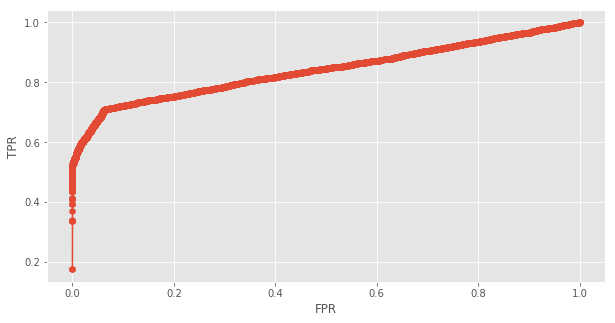

In [47]:
plt.figure(figsize=(10,5))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

###Impact of FP vs. FN

if false positive cost much higher, we should increase the probability threshold, but pay the price TPR is also decreased.
if false negative cost much higher, we should decrease the probability threshold, but pay the price FPR is also increased.

In [51]:
roc.loc[ (roc.TPR >= 0.82) & (roc.TPR <=0.83),:]

,FPR,TPR,Threshold
3289,0.411517,0.820291,0.044288
3290,0.411664,0.820291,0.044287
3291,0.411993,0.820291,0.044286
3292,0.412139,0.820637,0.044286
3293,0.412395,0.820637,0.044286
3294,0.412578,0.820637,0.044286
3295,0.412724,0.820637,0.044283
3296,0.413711,0.821330,0.044283
3297,0.413821,0.821330,0.044282
3298,0.413931,0.821330,0.044281


In this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, whose result will be further investigated by expert, so

   If 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
   But if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.
 
So in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.

From a user perspective. What kinds of users are more likely to be classiﬁed as at risk? What are their characteristics?

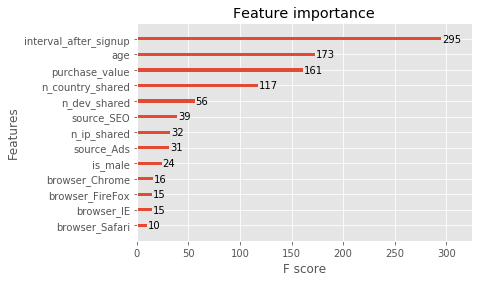

In [52]:
# First we plot the feature importance from GBM
xgb.plot_importance(gbt)

From model above, we can see that, 'interval_after_signup' is the most important factor helping us to decide a transaction is fraud or not.

To better understand, we fit a shallow, simple Decision Tree and plot it.

In [64]:
import graphviz
from IPython.display import Image
from os import system

C:\Users\siyue\Anaconda3\lib\site-packages\sklearn\tree\export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  try:


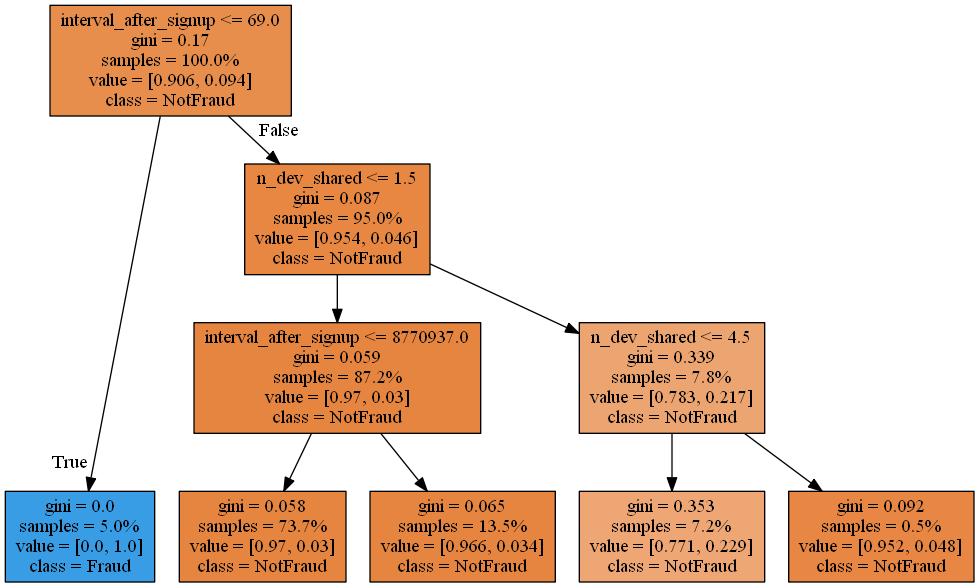

In [67]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
export_graphviz(dt,feature_names=X.columns,class_names=['NotFraud','Fraud'],
                proportion=True,leaves_parallel=True,filled=True)
system("dot -Tpng tree.dot -o dtree.png")
Image(filename='dtree.png')

From above plot, we focus on two leaf-nodes:

   The blue leaf node indicates, if 'interval_after_signup' is <=69 seconds, which means the customer purchases immediatelly after signup, then there is very high probability that this transaction is fraud.
   The leaf-node with positive ratio=22% (the second node from right), if the purchase is from a device shared by 2~4 users, then there is above-normal probability that the transaction is fraud.

###What kind of diﬀerent user experiences would you build based on the model output?

Since my model can predict the probability a purchase is fraud, so I need to set two probability cutoffs as 'alert value', alert1 and alert2, and alert1 < alert2 .

For a incoming purchase, my model will return the probability 'p' that the purchase is fraud,

1. If p < alert1, then I assume the purchase is normal, proceed without any problem
2. If alert1 <= p < alert2, then I assume the purchase is suspicious, I will ask the customer for additional authroization. for example, send email or SMS to the customer, let him/her authorize the purchase.
3. If p>= alert2, then the purchase is highly suspicious, I not only ask the customer for additional authorization via email or SMS, but also put the purchase on hold and send the purchase information to some human expert for further investigation.